In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from src.models import ResNet
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 80
batch_size = 100
learning_rate = 0.001
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
#stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))


# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified


# Visualize some of the training data

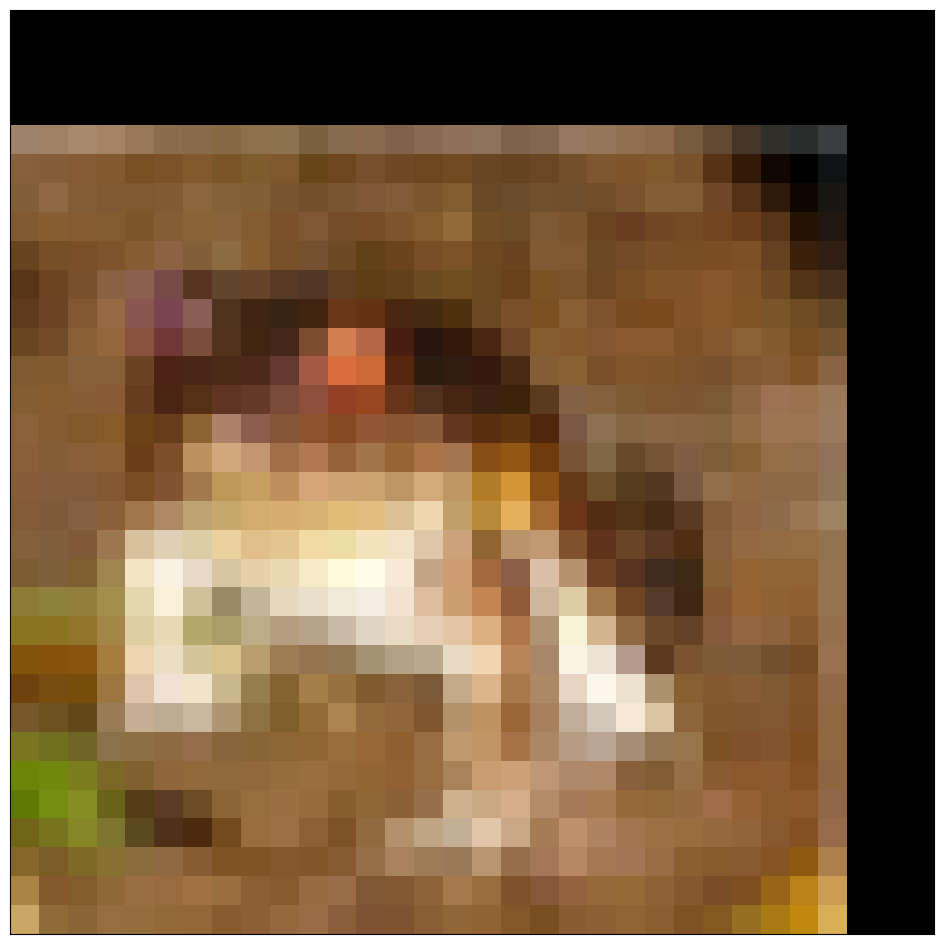

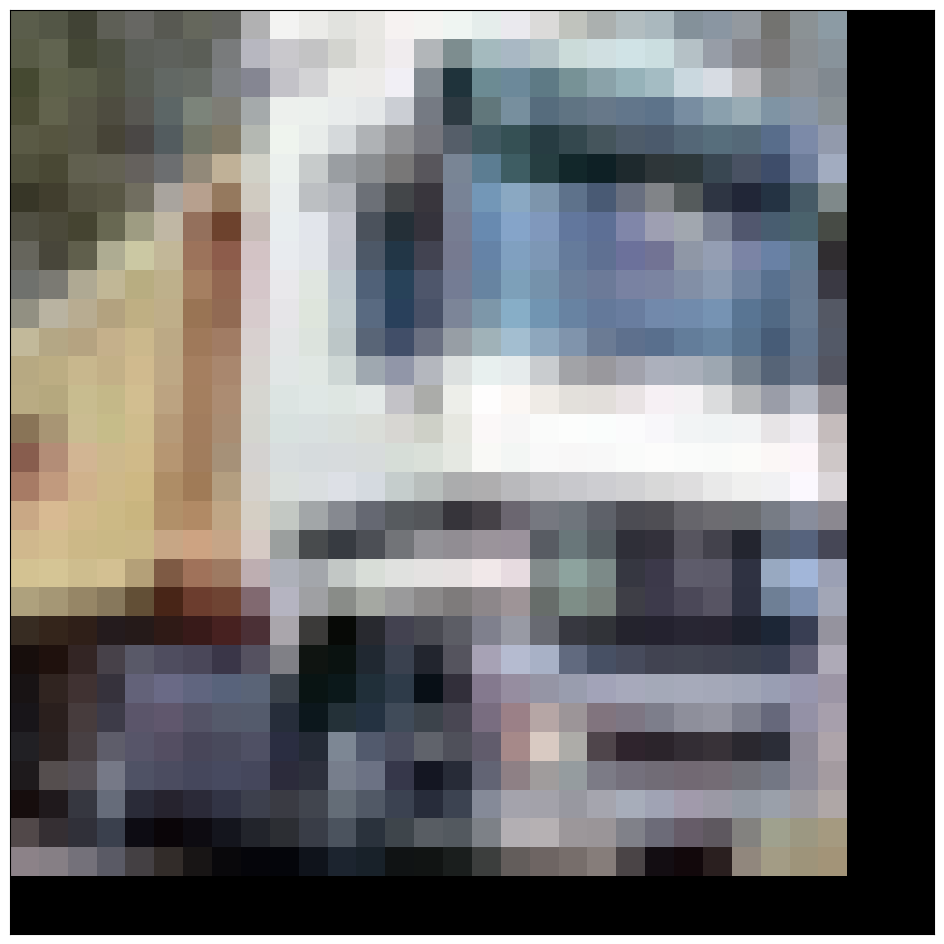

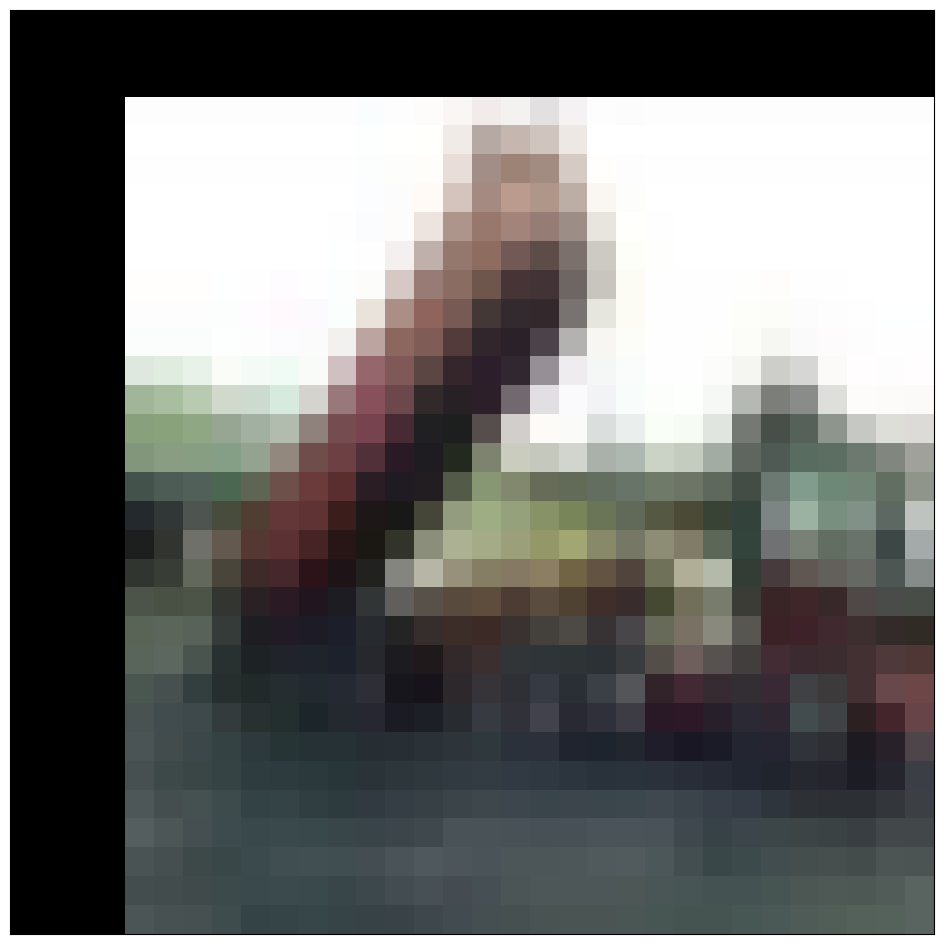

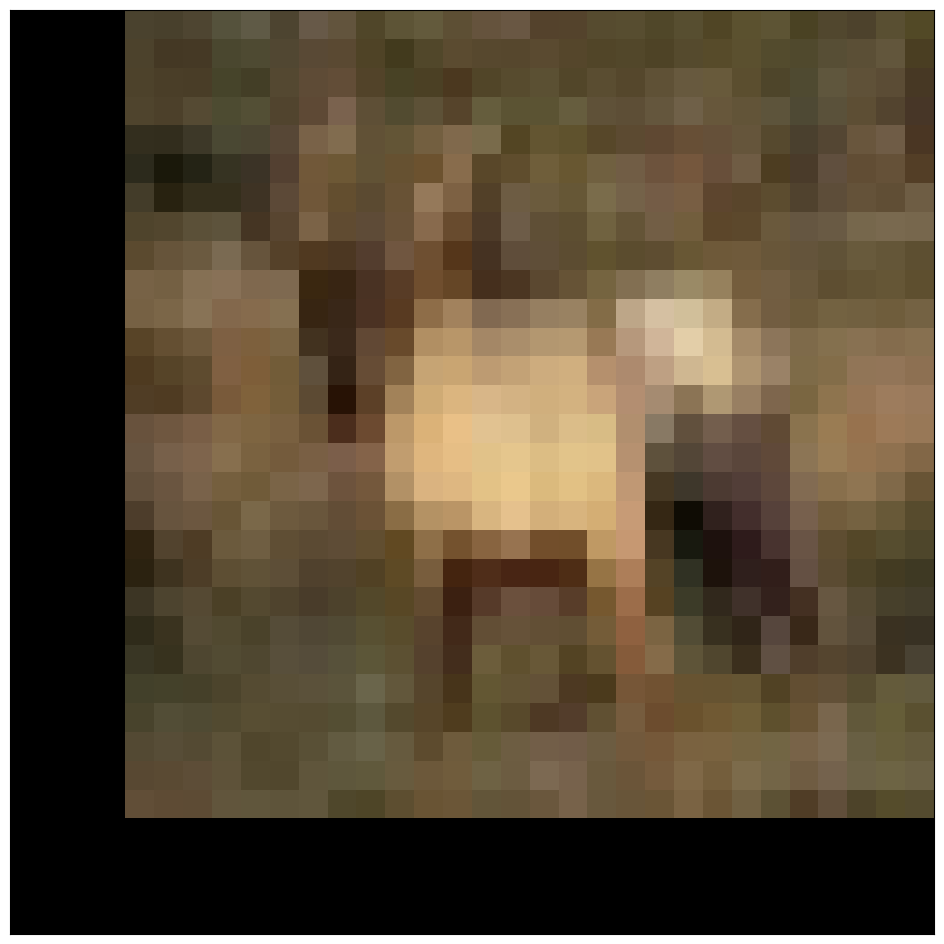

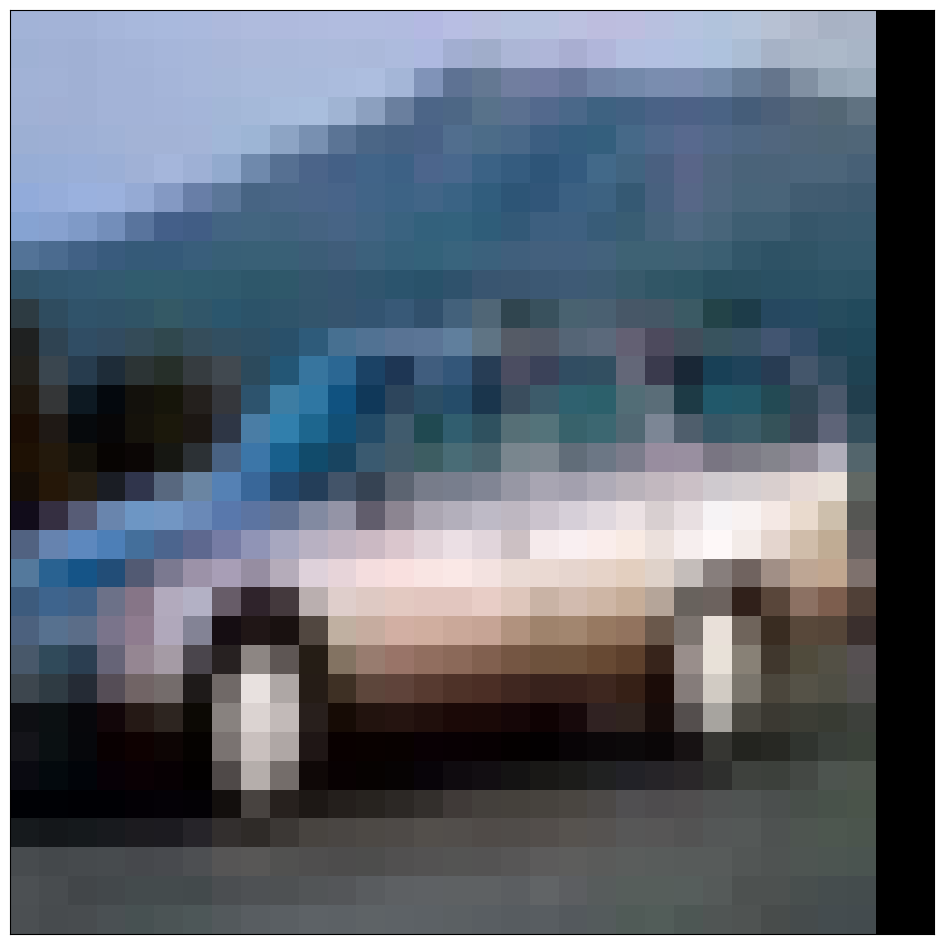

In [3]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

i = 0
for images, labels in train_dataset:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images, nrow=8).permute(1, 2, 0).clamp(0,1))
        i += 1
        if i >= 5:
            break
        

In [4]:
resnet = ResNet(in_channels=16, num_classes=10)
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [5]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate)


In [6]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = resnet(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Save the model checkpoint
torch.save(resnet.state_dict(), 'resnet.ckpt')


Epoch [1/80], Step [100/500], Loss: 1.6597
Epoch [1/80], Step [200/500], Loss: 1.5143
Epoch [1/80], Step [300/500], Loss: 1.3115
Epoch [1/80], Step [400/500], Loss: 1.1933
Epoch [1/80], Step [500/500], Loss: 1.2585
Epoch [2/80], Step [100/500], Loss: 1.0379
Epoch [2/80], Step [200/500], Loss: 1.2477
Epoch [2/80], Step [300/500], Loss: 0.9151
Epoch [2/80], Step [400/500], Loss: 1.1285
Epoch [2/80], Step [500/500], Loss: 0.9303
Epoch [3/80], Step [100/500], Loss: 1.0973
Epoch [3/80], Step [200/500], Loss: 0.7247
Epoch [3/80], Step [300/500], Loss: 0.9803
Epoch [3/80], Step [400/500], Loss: 0.8689
Epoch [3/80], Step [500/500], Loss: 0.6966
Epoch [4/80], Step [100/500], Loss: 0.6708
Epoch [4/80], Step [200/500], Loss: 0.7304
Epoch [4/80], Step [300/500], Loss: 0.5850
Epoch [4/80], Step [400/500], Loss: 0.7302
Epoch [4/80], Step [500/500], Loss: 0.7242
Epoch [5/80], Step [100/500], Loss: 0.6566
Epoch [5/80], Step [200/500], Loss: 0.6212
Epoch [5/80], Step [300/500], Loss: 0.7382
Epoch [5/80

In [7]:
import torch
import torch.nn as nn
from torch.quantization import QuantStub, DeQuantStub, quantize_static

# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Create an instance of the MLP model
model = MLP()

# Define the input data shape
input_shape = (1, 784)

# Define the input data and the target labels
input_data = torch.randn(input_shape)
target_labels = torch.randn((1, 10))

# Apply quantization to the weights of the MLP model
quantized_model = quantize_static(model, qconfig_spec={nn.Linear: torch.quantization.default_qconfig}, dtype=torch.qint8)

# Train and evaluate the quantized model
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(quantized_model.parameters(), lr=0.01)

for i in range(100):
    output = quantized_model(input_data)
    loss = criterion(output, target_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Dequantize the quantized model for evaluation
dequantized_model = torch.quantization.dequantize(quantized_model)

# Evaluate the dequantized model on the test dataset
test_data = ...
test_labels = ...
test_output = dequantized_model(test_data)
test_loss = criterion(test_output, test_labels)
print('Test Loss: {:.4f}'.format(test_loss.item()))


ImportError: cannot import name 'quantize_static' from 'torch.quantization' (/home/isaac/.local/lib/python3.8/site-packages/torch/quantization/__init__.py)